## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The gridded EPA U.S. anthropogenic methane greenhouse gas inventory (gridded GHGI) includes spatially disaggregated (0.1 deg x 0.1 deg or approximately 10 x 10 km resolution) maps of annual anthropogenic methane emissions (for the contiguous United States (CONUS), consistent with national annual U.S. anthropogenic methane emissions reported in the U.S. EPA [Inventory of U.S. Greenhouse Gas Emissions and Sinks](https://www.epa.gov/ghgemissions/inventory-us-greenhouse-gas-emissions-and-sinks) (U.S. GHGI). This V2 Express Extension dataset contains methane emissions provided as fluxes, in units of molecules of methane per square cm per second, for over 25 individual emission source categories, including those from agriculture, petroleum and natural gas systems, coal mining, and waste. The data have been converted from their original NetCDF format to Cloud-Optimized GeoTIFF (COG) for use in the US GHG Center, thereby enabling user exploration of spatial anthropogenic methane emissions and their trends.

# Installing the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests, folium, rasterstats, pystac_client, pandas, matplotlib

## Querying the STAC API

In [45]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import pandas as pd
import matplotlib.pyplot as plt
import branca.colormap as cm
import geopandas
from pyproj import Geod
from shapely import wkt

In [46]:
# Loading Permian Basin shape file as a region of interest
# User can pass any json or shape file here
permian_basin = geopandas.read_file('../interactive-session-3-large-point-source-methane-emission-events/permian.zip')

In [47]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for gridded methane dataset. 
collection_name = "epa-ch4emission-yeargrid-v2express-new"

In [48]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'epa-ch4emission-yeargrid-v2express-new',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'}],
 'title': 'Gridded annual U.S. anthropogenic methane emissions 2012-2020',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-130,
     19.999998092651367,
     -60,
     55.000003814697266]]},
  'temporal': {'interval': [['2012-01-01T00:00:00+00:00',
     '2020-01-01T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['2012-01-01T00:00:00Z', '2020-01-01T00:00:00Z']},


In [49]:
collection['item_assets'].keys()

dict_keys(['dwtd-waste', 'iwtd-waste', 'post-meter', 'refining-ps', 'total-other', 'total-waste', 'surface-coal', 'transport-ps', 'abn-ong-other', 'field-burning', 'production-ps', 'total-methane', 'exploration-ps', 'processing-ngs', 'production-ngs', 'exploration-ngs', 'composting-waste', 'distribution-ngs', 'rice-cultivation', 'total-coal-mines', 'underground-coal', 'manure-management', 'total-agriculture', 'msw-landfill-waste', 'abn-underground-coal', 'enteric-fermentation', 'petro-production-other', 'mobile-combustion-other', 'total-petroleum-systems', 'transmission-storage-ngs', 'industrial-landfill-waste', 'total-natural-gas-systems', 'ferroalloy-production-other', 'stationary-combustion-other'])

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2012 to December 2020. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is yearly.

In [50]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [51]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 9 items


In [52]:
# Examining the first item in the collection
items[0]

{'id': 'epa-ch4emission-yeargrid-v2express-new-2020',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new/items/epa-ch4emission-yeargrid-v2express-new-2020'}],
 'assets': {'dwtd-waste': {'href': 's3://ghgc-data-store/epa-ch4emission-yeargrid-v2express-new/Express_Extension_emi_ch4_5D_Wastewater_Treatment_Domestic_Gridded_GHGI_Methane_v2_2020.tif',
   'type': 'image/tiff; application=geotiff; p

This makes sense as there are 9 years between 2012 - 2020, meaning 9 records in total.  

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values.`

## Exploring Changes in Methane (CH4) Levels Using the Raster API

In this notebook, we will explore the impacts of methane emissions and by examining changes over time in urban regions. We will visualize the outputs on a map using `folium.`

In [53]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"][:7]: item for item in items} 
asset_name_1 = "production-ngs"
asset_name_2 = 'production-ps'
asset_name_3 = 'total-methane'

In [54]:
# Fetching the min and max values for a specific item
rescale_values = {'max': 20,'min': 0}

In [55]:
items

{'2020-01': {'id': 'epa-ch4emission-yeargrid-v2express-new-2020',
  'bbox': [-129.99999694387628,
   19.99999923487448,
   -60.00000305612369,
   55.00000076512553],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://ghg.center/api/stac/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new/items/epa-ch4emission-yeargrid-v2express-new-2020'}],
  'assets': {'dwtd-waste': {'href': 's3://ghgc-data-store/epa-ch4emission-yeargrid-v2express-new/Express_Extension_emi_ch4_5D_Wastewater_Treatment_Domestic_Gridded_GHGI_Methane_v2_2020.tif',
    'type': 'ima

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for January 2018 and again for January 2012, so that we can visualize each event independently.

In [56]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2018_tile_ps = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2018-01']['collection']}&item={items['2018-01']['id']}"
    f"&assets={asset_name_1}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2018_tile_ps

january_2012_tile_ps = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2012-01']['collection']}&item={items['2012-01']['id']}"
    f"&assets={asset_name_1}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2012_tile_ps

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4emission-yeargrid-v2express-new&item=epa-ch4emission-yeargrid-v2express-new-2012&assets=production-ngs&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0%2C20'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [57]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2018_tile_ngs = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2018-01']['collection']}&item={items['2018-01']['id']}"
    f"&assets={asset_name_2}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2018_tile_ngs

january_2012_tile_ngs = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2012-01']['collection']}&item={items['2012-01']['id']}"
    f"&assets={asset_name_2}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2012_tile_ngs

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4emission-yeargrid-v2express-new&item=epa-ch4emission-yeargrid-v2express-new-2012&assets=production-ps&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0%2C20'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

In [58]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2018_tile_tm = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2018-01']['collection']}&item={items['2018-01']['id']}"
    f"&assets={asset_name_3}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2018_tile_tm

january_2012_tile_tm = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2012-01']['collection']}&item={items['2012-01']['id']}"
    f"&assets={asset_name_3}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2012_tile_tm

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=epa-ch4emission-yeargrid-v2express-new&item=epa-ch4emission-yeargrid-v2express-new-2012&assets=total-methane&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0%2C20'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'center': [-94.99999999999999, 37.5, 0]}

## Visualizing CH₄ emissions


In [59]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(32, -102), zoom_start=6)

# January 2018
map_layer_2018 = TileLayer(
    tiles=january_2018_tile_ps["tiles"][0],
    name = 'Petroleum production for 2018',
    attr="GHG",
    opacity=0.7,
)
map_layer_2018.add_to(map_.m1)

# January 2012
map_layer_2012 = TileLayer(
    tiles=january_2012_tile_ps["tiles"][0],
    name = 'Petroleum production for 2012',
    attr="GHG",
    opacity=0.7,
)
map_layer_2012.add_to(map_.m2)

map_layer_permian = folium.GeoJson(permian_basin, name= 'Permian Shape')
map_layer_permian.add_to(map_)
folium.LayerControl(collapsed=True, position='bottomleft').add_to(map_)
# visualising the map
map_

# visualising the map
map_



In [60]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(32, -102), zoom_start=6)

# January 2018
map_layer_2018 = TileLayer(
    tiles=january_2018_tile_ngs["tiles"][0],
    name = 'Natural Gas production for 2018',
    attr="GHG",
    opacity=0.7,
)
map_layer_2018.add_to(map_.m1)

# January 2012
map_layer_2012 = TileLayer(
    tiles=january_2012_tile_ngs["tiles"][0],
    name = 'Natural Gas Production for 2012',
    attr="GHG",
    opacity=0.7,
)
map_layer_2012.add_to(map_.m2)

map_layer_permian = folium.GeoJson(permian_basin, name= 'Permian Shape')
map_layer_permian.add_to(map_)
folium.LayerControl(collapsed=True, position='bottomleft').add_to(map_)
# visualising the map
map_

# visualising the map
map_



In [61]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(32, -102), zoom_start=6)

# January 2018
map_layer_2018 = TileLayer(
    tiles=january_2018_tile_tm["tiles"][0],
    attr="GHG",
    name = 'Total methane emissions for 2018',
    opacity=0.7,
)
map_layer_2018.add_to(map_.m1)

# January 2012
map_layer_2012 = TileLayer(
    tiles=january_2012_tile_tm["tiles"][0],
    name= 'Total methane emissions for 2012',
    attr="GHG",
    opacity=0.7,
)
map_layer_2012.add_to(map_.m2)

map_layer_permian = folium.GeoJson(permian_basin, name= 'Permian Shape')
map_layer_permian.add_to(map_)
folium.LayerControl(collapsed=True, position='bottomleft').add_to(map_)
# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [62]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [63]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [64]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 9 items


In [65]:
# Explore the first item
items[0]

{'id': 'epa-ch4emission-yeargrid-v2express-new-2020',
 'bbox': [-129.99999694387628,
  19.99999923487448,
  -60.00000305612369,
  55.00000076512553],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/epa-ch4emission-yeargrid-v2express-new/items/epa-ch4emission-yeargrid-v2express-new-2020'}],
 'assets': {'dwtd-waste': {'href': 's3://ghgc-data-store/epa-ch4emission-yeargrid-v2express-new/Express_Extension_emi_ch4_5D_Wastewater_Treatment_Domestic_Gridded_GHGI_Methane_v2_2020.tif',
   'type': 'image/tiff; application=geotiff; p

In [66]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name_3]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

With the function above we can generate the statistics for the AOI.

In [67]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 149 ms, sys: 19.9 ms, total: 169 ms
Wall time: 5.52 s


In [68]:
stats[0]

{'statistics': {'b1': {'min': -9999.0,
   'max': 227.91432189941406,
   'mean': -363.9322916666667,
   'count': 3600.0,
   'sum': -1310156.25,
   'std': 1887.1677703772536,
   'median': 2.123157262802124,
   'majority': -9999.0,
   'minority': 0.0025735695380717516,
   'unique': 3455.0,
   'histogram': [[133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3467.0],
    [-9999.0,
     -8976.30859375,
     -7953.6171875,
     -6930.92578125,
     -5908.234375,
     -4885.54296875,
     -3862.851318359375,
     -2840.159912109375,
     -1817.468505859375,
     -794.777099609375,
     227.91432189941406]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 3600.0,
   'percentile_2': -9999.0,
   'percentile_98': 34.91124908447266}},
 'datetime': '2020-01-01T00:00:00+00:00'}

In [69]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,-9999.0,227.914322,-363.932292,3600.0,-1310156.250,1887.167770,2.123157,-9999.0,0.002574,3455.0,"[[133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",100.0,0.0,3600.0,-9999.0,34.911249,2020-01-01 00:00:00+00:00
1,2019-01-01T00:00:00+00:00,-9999.0,238.397369,-363.716771,3600.0,-1309380.375,1887.213078,2.132977,-9999.0,0.002583,3454.0,"[[133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",100.0,0.0,3600.0,-9999.0,36.138971,2019-01-01 00:00:00+00:00
2,2018-01-01T00:00:00+00:00,-9999.0,233.858093,-363.873160,3600.0,-1309943.375,1887.180645,2.131521,-9999.0,0.002580,3455.0,"[[133.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",100.0,0.0,3600.0,-9999.0,35.664083,2018-01-01 00:00:00+00:00
3,2017-01-01T00:00:00+00:00,-9999.0,262.567780,-355.611111,3600.0,-1280200.000,1866.566856,2.165620,-9999.0,0.000023,3456.0,"[[130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",100.0,0.0,3600.0,-9999.0,34.349503,2017-01-01 00:00:00+00:00
4,2016-01-01T00:00:00+00:00,-9999.0,278.727905,-355.599479,3600.0,-1280158.125,1866.574553,2.128528,-9999.0,0.000023,3459.0,"[[130.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",100.0,0.0,3600.0,-9999.0,34.211210,2016-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the gridded methane emission (Domestic Wastewater Treatment & Discharge (5D)) time series (January 2000 -December 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2012-2018)')

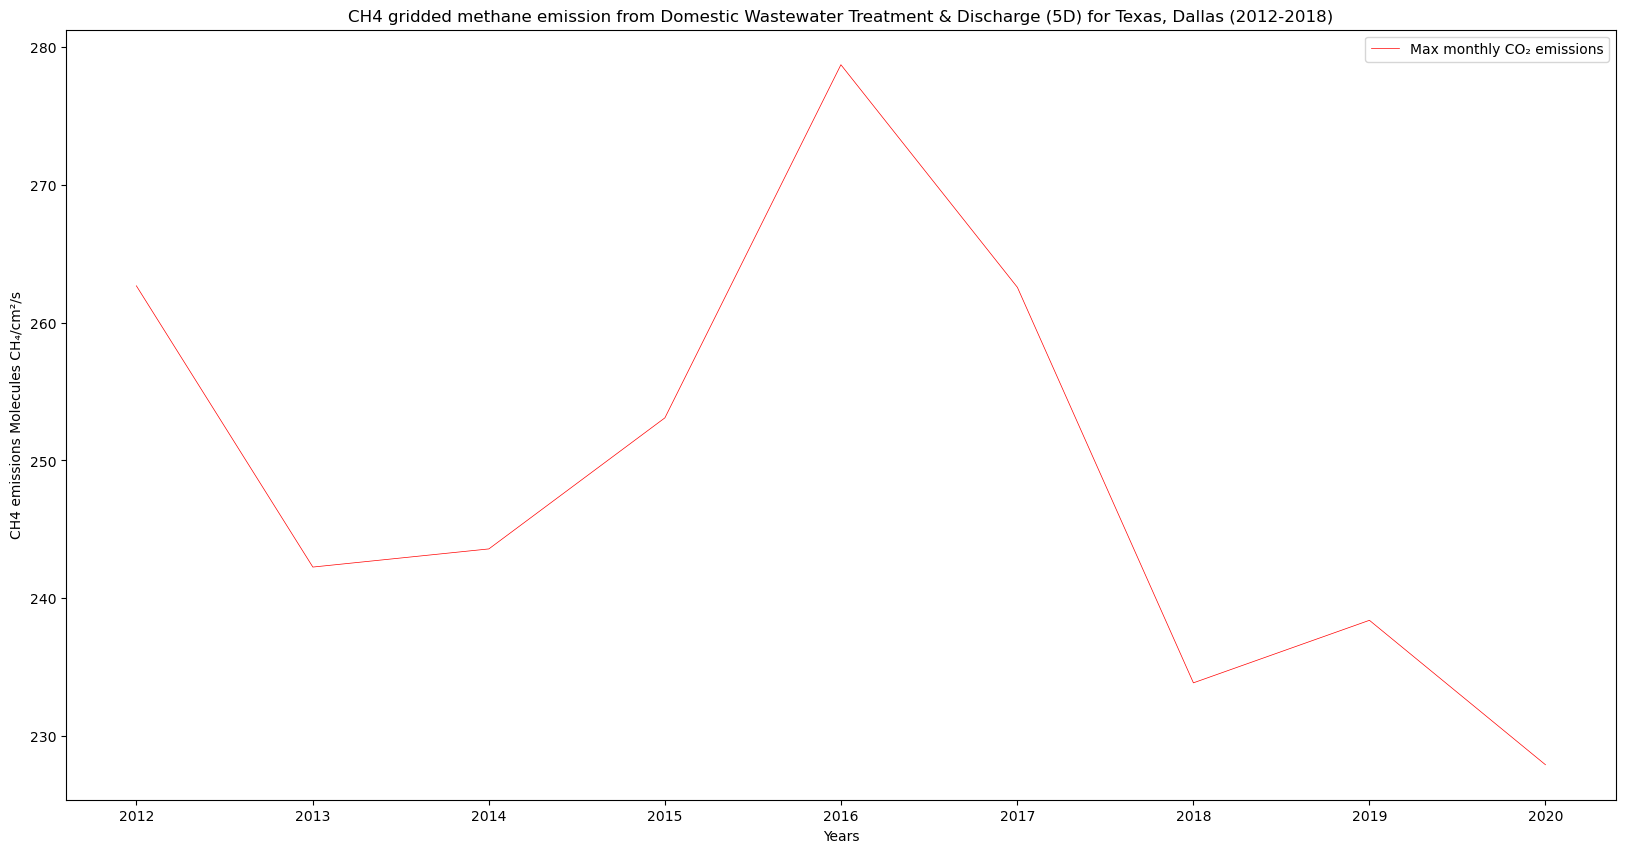

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO₂ emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CH4 emissions Molecules CH₄/cm²/s")
plt.title("CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2012-2018)")

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for gridded methane emissions.